In [1]:
!pip install torchview
from torchview import draw_graph

In [2]:
import os
import random
import numpy as np
import seaborn as sns
from tqdm import tqdm
from google.colab import drive
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [3]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
#Unziping the data
!unzip -qq "/content/drive/MyDrive/Project Deals/DeepLearning2023/FR_new/Dataset/archive.zip"

In [5]:
WEIGHTS_FOLDER="/content/drive/MyDrive/Project Deals/DeepLearning2023/FR_new/Weights"
DIAGRAM_FOLDER="/content/drive/MyDrive/Project Deals/DeepLearning2023/FR_new/Diagram"

In [6]:
#paths:
train_directory="/content/train"
test_directory="/content/test"

In [7]:
label_to_name = {0:'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}

In [8]:
def classification_metric(y_true,y_pred):
  accuracy  = accuracy_score(y_true, y_pred)
  precision = [round(i,2) for i in precision_score(y_true, y_pred,average=None,zero_division=0)]
  recall    = [round(i,2) for i in recall_score(y_true, y_pred,average=None,zero_division=0)]
  f1_value  = [round(i,2) for i in f1_score(y_true, y_pred,average=None,zero_division=0)]
  print("Accuracy is:                 ", round(accuracy,3))
  print("Precision of each class is:  ",*precision)
  print("Recall of each class is:     ",*recall)
  print("F1_score of each class is:   ",*f1_value)


def make_confusion_matrix(y_true,y_pred):
  cm = confusion_matrix(y_true,y_pred)
  plt.figure(figsize = (6,6))
  sns.heatmap(cm, annot=True)
  plt.show()

## Loading Data and Preprocessing

In [9]:
BATCH_SIZE = 32

In [10]:
#Here the data value would be tranformed between 0 and 1
data_transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    # transforms.RandomPerspective(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#load the data
train_dataset = ImageFolder(train_directory, transform=data_transform_train)
test_dataset = ImageFolder(test_directory, transform=data_transform)

train_size = len(train_dataset)
ts=(train_size*75)//100
vs=train_size-ts
train_dataset, val_dataset = data.random_split(train_dataset, [ts,vs])

print(f"Training data length: {len(train_dataset)}\nTesting data length: {len(test_dataset)}\nValidation data length: {len(val_dataset)}")

Training data length: 21531
Testing data length: 7178
Validation data length: 7178


In [11]:
#Load the data into a dataloder of pytorch
train_dataloader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_dataloader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##Know your data

##1. Number of images belonging to each class of expressions

In [13]:
#Labels in Train data:
data = {}
for _,label in train_dataset:
  v=label
  label_class=label_to_name[v]
  data[label_class]=data.get(label_class,0)+1

data={key:data[key] for key in label_to_name.values()}

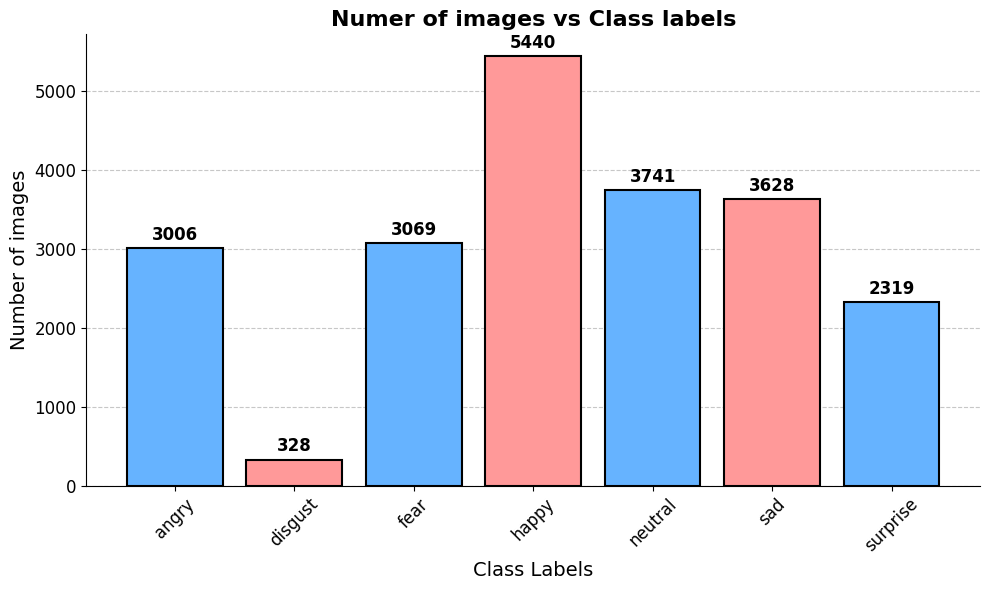

In [14]:
keys = list(data.keys())
values = list(data.values())

# Define a custom color palette
colors = ['#66b3ff', '#ff9999']

# Plotting the data
plt.figure(figsize=(10, 6))
bars = plt.bar(keys, values, color=colors, edgecolor='black', linewidth=1.5)

for bar in bars:
    height = bar.get_height()
    plt.annotate('{}'.format(height),
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("Class Labels", fontsize=14)
plt.ylabel("Number of images", fontsize=14)
plt.title("Numer of images vs Class labels", fontsize=16, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().set_axisbelow(True)

plt.show()

##2. Sample Train data

In [15]:
def show_images_labels(images, labels):
    # Unnormalize and convert tensors to numpy arrays for visualization
    images = images.numpy().transpose((0, 2, 3, 1))  # Change tensor shape to (batch_size, H, W, C)
    mean = [0.485, 0.456, 0.406] #Mean of Image
    std = [0.229, 0.224, 0.225]  #standard deviation of Image
    images = images * std + mean  # Unnormalize
    images = np.clip(images, 0, 1)
    num_images = len(images)
    num_rows = (num_images + 3) // 6

    fig, axes = plt.subplots(num_rows, 6, figsize=(16, 4 * num_rows))

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(images[i])
            ax.set_title(f"Label: {label_to_name[labels[i].item()]}")
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

### Test dataset visualization

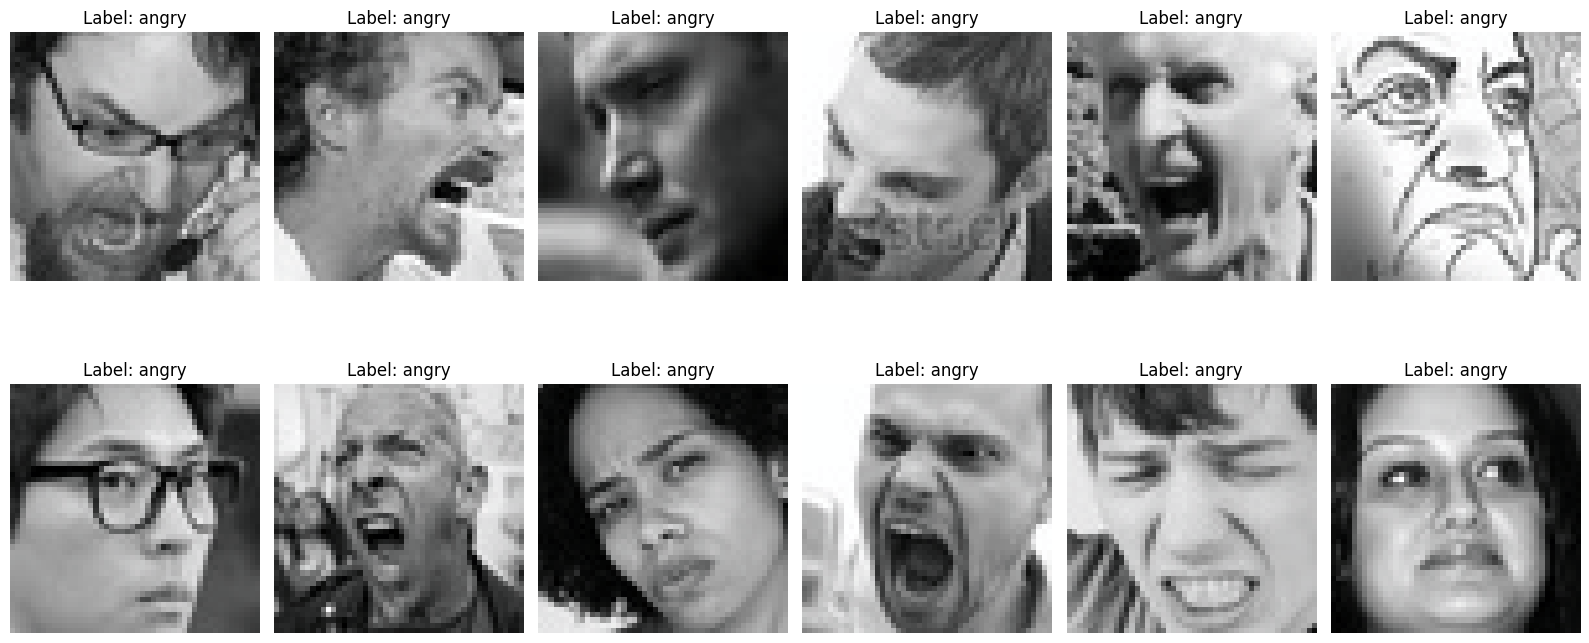

In [16]:
#Test Images without augmentation
for images, labels in test_dataloader:
    show_images_labels(images[:12], labels[:12])
    break

### Augmentation applied on Train dataset

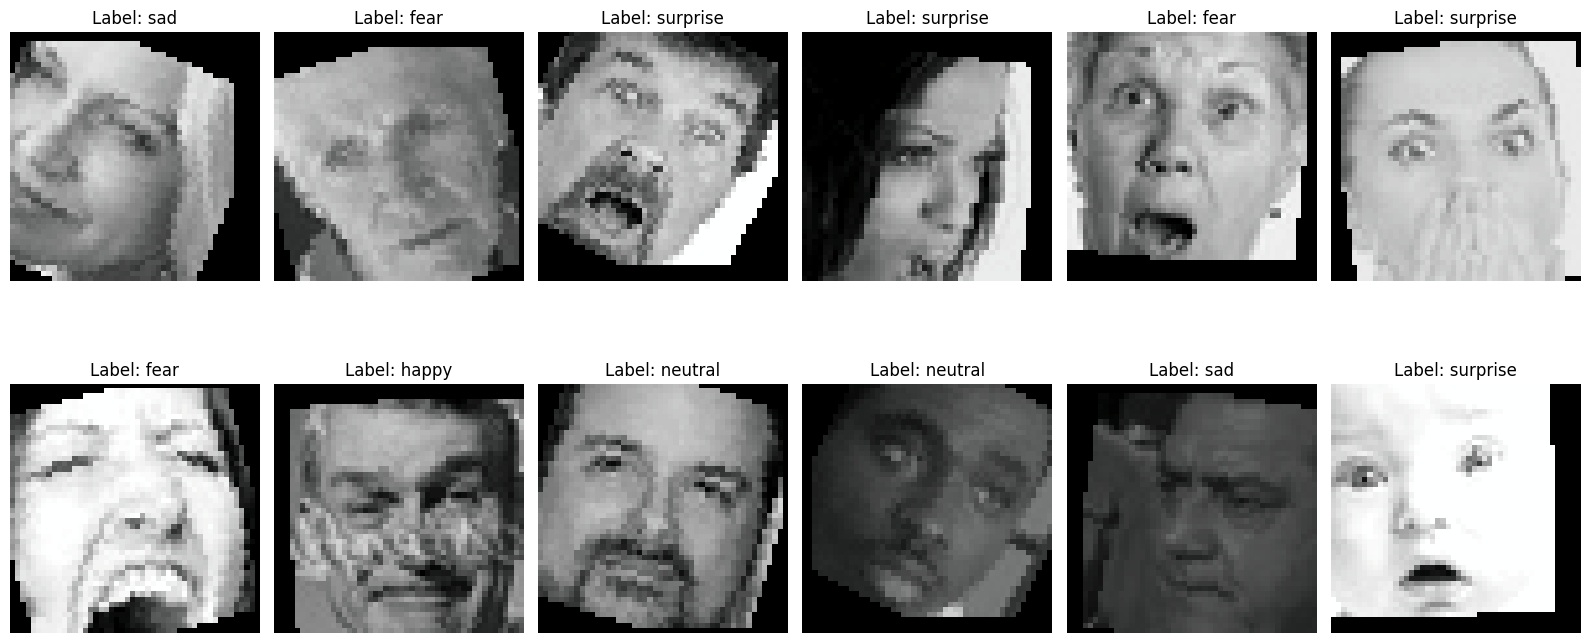

In [17]:
#Train Images with augmentation
for images, labels in train_dataloader:
    show_images_labels(images[:12], labels[:12])
    break

## CNN model

In [18]:
def train_model(num_epochs,model,optimizer,criterion,model_class=None,thresh=10):
  Train_loss=[]
  Train_accuracy=[]
  Val_loss=[]
  Val_accuracy=[]
  threshold=thresh
  stop_threshold=threshold
  l2_regularization=0.00001
  best_loss=10**10
  best_acc=0
  for epoch in tqdm(range(num_epochs)):
      train_loss = 0.0
      val_loss = 0.0
      train_total = 0
      val_total = 0
      train_correct = 0
      val_correct =0

      for i, (images, labels) in enumerate(train_dataloader):
          images = images.to(device)
          labels = labels.to(device)

          # Forward pass
          model.train()
          outputs = model(images)
          loss = criterion(outputs, labels)

          # Backward
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()

          train_loss += loss.item() * images.size(0)

          # Accuracy
          _, predicted = torch.max(outputs.data, 1)
          train_total += labels.size(0)
          train_correct += (predicted == labels).sum().item()

      # Validation
      model.eval()
      with torch.no_grad():
          for images, labels in val_dataloader:
              images = images.to(device)
              labels = labels.to(device)

              outputs = model(images)
              loss = criterion(outputs, labels)

              val_loss += loss.item() * images.size(0)

              _, predicted = torch.max(outputs.data, 1)
              val_total += labels.size(0)
              val_correct += (predicted == labels).sum().item()

      train_loss = train_loss / len(train_dataloader.dataset)
      val_loss = val_loss / len(val_dataloader.dataset)
      train_accuracy = train_correct / train_total
      val_accuracy = val_correct / val_total

      #Appending value at each epoch
      Train_accuracy.append(train_accuracy)
      Val_accuracy.append(val_accuracy)
      Train_loss.append(train_loss)
      Val_loss.append(val_loss)

      #Early stoppage
      if(val_loss<best_loss or val_accuracy>best_acc):
        best_loss=min(val_loss,best_loss)
        best_acc=max(best_acc,val_accuracy)
        best_model_state=model.state_dict()
        stop_threshold=threshold
      else:
        stop_threshold-=1
      if not stop_threshold:
        break

      print(f"Epoch [{epoch+1}/{num_epochs}] : Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f},  Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")
  if not model_class is None:
    model = model_class()
    model.load_state_dict(best_model_state)
    model.to(device)
  info=[Train_accuracy,Val_accuracy,Train_loss,Val_loss]
  return model,info

In [19]:
#Method to test the model
def test_model(model, criterion, data_loader):
  model.eval()  # Set the model to evaluation mode
  total_correct = 0
  total_samples = 0
  total_loss = 0.0
  y_test=np.array([])
  y_pred=np.array([])
  with torch.no_grad():
      for inputs, labels in data_loader:
          inputs=inputs.to(device)
          labels=labels.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs.data, 1)
          y_test=np.append(y_test,labels.cpu().numpy())
          y_pred=np.append(y_pred,predicted.cpu().numpy())
  classification_metric(y_test,y_pred)
  print("\n"*2)
  print("Confusion Matrix")
  make_confusion_matrix(y_test,y_pred)

In [20]:
#Method to plot loss and accuracy graphs
def plot_loss_accuracy(model_info):
  # Plot loss and accuracy
  fig, axs = plt.subplots(1, 2,figsize=(12,5))

  x_axis=range(len(model_info[0]))
  axs[0].plot(x_axis,model_info[0],label="Traning set")
  axs[0].plot(x_axis,model_info[1],label="Validation set")
  axs[0].set(ylabel="Accuracy")
  axs[0].set(xlabel="Epochs")

  axs[1].plot(x_axis,model_info[2],label="Traning set")
  axs[1].plot(x_axis,model_info[3],label="Validation set")
  axs[1].set(ylabel="Loss")
  axs[1].set(xlabel="Epochs")

  plt.legend()
  plt.show()

In [21]:
class CustomLoss(nn.Module):
    def __init__(self, class_weights):
        super(CustomLoss, self).__init__()
        self.weights = torch.Tensor(class_weights).to(device)

    def forward(self, outputs, targets):
        loss = nn.CrossEntropyLoss(weight=self.weights)(outputs, targets)
        return loss

In [22]:
#One sample input for diagrams
for sample_input,_ in train_dataloader:
  break
sample_input.shape

torch.Size([32, 3, 48, 48])

#1. Simple CNN model

In [ ]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        # nn.Conv2d()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(1152*4, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(256, 7)

    def forward(self, x):
        out = self.pool1(self.dropout1(self.relu1(self.bn1(self.conv1(x)))))
        out = self.pool2(self.dropout2(self.relu2(self.bn2(self.conv2(out)))))
        out = torch.flatten(out, 1)
        out = self.dropout3(self.relu3(self.bn3(self.fc1(out))))
        out = self.fc2(out)
        out = F.log_softmax(out, dim=-1)
        return out

In [ ]:
#Saving model diagram
save_path=os.path.join(DIAGRAM_FOLDER,"simple_cnn_model")
model_graph = draw_graph(CNN_Model(), input_size=(1,3,48,48), expand_nested=True)
model_graph.visual_graph.render(save_path, format="png", view=True)

'/content/drive/MyDrive/Project Deals/DeepLearning2023/FR_new/Diagram/simple_cnn_model.png'

In [ ]:
# Create a ResNet model
cnn_model = CNN_Model()

# Train your ResNet Model
model = cnn_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs=30

cnn_model,cnn_model_info=train_model(num_epochs,model,optimizer,criterion,CNN_Model)

  3%|▎         | 1/30 [00:43<20:58, 43.38s/it]

Epoch [1/30] : Train Loss: 1.7850, Val Loss: 1.7116,  Train Accuracy: 0.2817, Val Accuracy: 0.3169


  7%|▋         | 2/30 [01:26<20:14, 43.38s/it]

Epoch [2/30] : Train Loss: 1.6794, Val Loss: 1.7012,  Train Accuracy: 0.3262, Val Accuracy: 0.3201


 10%|█         | 3/30 [02:10<19:35, 43.54s/it]

Epoch [3/30] : Train Loss: 1.6377, Val Loss: 1.6172,  Train Accuracy: 0.3567, Val Accuracy: 0.3585


 13%|█▎        | 4/30 [02:53<18:42, 43.19s/it]

Epoch [4/30] : Train Loss: 1.5959, Val Loss: 1.5969,  Train Accuracy: 0.3748, Val Accuracy: 0.3775


 17%|█▋        | 5/30 [03:35<17:52, 42.89s/it]

Epoch [5/30] : Train Loss: 1.5637, Val Loss: 1.5701,  Train Accuracy: 0.3899, Val Accuracy: 0.3792


 20%|██        | 6/30 [04:18<17:13, 43.08s/it]

Epoch [6/30] : Train Loss: 1.5442, Val Loss: 1.5436,  Train Accuracy: 0.4004, Val Accuracy: 0.4090


 23%|██▎       | 7/30 [05:01<16:29, 43.01s/it]

Epoch [7/30] : Train Loss: 1.5254, Val Loss: 1.5238,  Train Accuracy: 0.4090, Val Accuracy: 0.4117


 27%|██▋       | 8/30 [05:43<15:40, 42.74s/it]

Epoch [8/30] : Train Loss: 1.5078, Val Loss: 1.5013,  Train Accuracy: 0.4190, Val Accuracy: 0.4218


 30%|███       | 9/30 [06:27<15:00, 42.86s/it]

Epoch [9/30] : Train Loss: 1.4913, Val Loss: 1.5043,  Train Accuracy: 0.4237, Val Accuracy: 0.4206


 33%|███▎      | 10/30 [07:10<14:20, 43.03s/it]

Epoch [10/30] : Train Loss: 1.4846, Val Loss: 1.4832,  Train Accuracy: 0.4285, Val Accuracy: 0.4324


 37%|███▋      | 11/30 [07:52<13:28, 42.57s/it]

Epoch [11/30] : Train Loss: 1.4750, Val Loss: 1.4823,  Train Accuracy: 0.4340, Val Accuracy: 0.4335


 40%|████      | 12/30 [08:35<12:50, 42.78s/it]

Epoch [12/30] : Train Loss: 1.4636, Val Loss: 1.4688,  Train Accuracy: 0.4349, Val Accuracy: 0.4447


 43%|████▎     | 13/30 [09:19<12:12, 43.07s/it]

Epoch [13/30] : Train Loss: 1.4503, Val Loss: 1.4654,  Train Accuracy: 0.4431, Val Accuracy: 0.4316


 47%|████▋     | 14/30 [10:01<11:23, 42.74s/it]

Epoch [14/30] : Train Loss: 1.4389, Val Loss: 1.4430,  Train Accuracy: 0.4494, Val Accuracy: 0.4508


 50%|█████     | 15/30 [10:44<10:42, 42.82s/it]

Epoch [15/30] : Train Loss: 1.4317, Val Loss: 1.4460,  Train Accuracy: 0.4511, Val Accuracy: 0.4395


 53%|█████▎    | 16/30 [11:27<10:01, 42.94s/it]

Epoch [16/30] : Train Loss: 1.4255, Val Loss: 1.4493,  Train Accuracy: 0.4543, Val Accuracy: 0.4430


 57%|█████▋    | 17/30 [12:09<09:14, 42.69s/it]

Epoch [17/30] : Train Loss: 1.4183, Val Loss: 1.4391,  Train Accuracy: 0.4583, Val Accuracy: 0.4546


 60%|██████    | 18/30 [12:52<08:32, 42.70s/it]

Epoch [18/30] : Train Loss: 1.4048, Val Loss: 1.4227,  Train Accuracy: 0.4643, Val Accuracy: 0.4631


 63%|██████▎   | 19/30 [13:35<07:50, 42.81s/it]

Epoch [19/30] : Train Loss: 1.4058, Val Loss: 1.4172,  Train Accuracy: 0.4586, Val Accuracy: 0.4583


 67%|██████▋   | 20/30 [14:17<07:07, 42.79s/it]

Epoch [20/30] : Train Loss: 1.4016, Val Loss: 1.4089,  Train Accuracy: 0.4655, Val Accuracy: 0.4724


 70%|███████   | 21/30 [14:59<06:23, 42.58s/it]

Epoch [21/30] : Train Loss: 1.3876, Val Loss: 1.4080,  Train Accuracy: 0.4667, Val Accuracy: 0.4575


 73%|███████▎  | 22/30 [15:43<05:42, 42.87s/it]

Epoch [22/30] : Train Loss: 1.3919, Val Loss: 1.4033,  Train Accuracy: 0.4699, Val Accuracy: 0.4675


 77%|███████▋  | 23/30 [16:27<05:01, 43.11s/it]

Epoch [23/30] : Train Loss: 1.3836, Val Loss: 1.3798,  Train Accuracy: 0.4712, Val Accuracy: 0.4735


 80%|████████  | 24/30 [17:08<04:15, 42.66s/it]

Epoch [24/30] : Train Loss: 1.3762, Val Loss: 1.3929,  Train Accuracy: 0.4736, Val Accuracy: 0.4696


 83%|████████▎ | 25/30 [17:52<03:34, 42.87s/it]

Epoch [25/30] : Train Loss: 1.3663, Val Loss: 1.4039,  Train Accuracy: 0.4787, Val Accuracy: 0.4652


 87%|████████▋ | 26/30 [18:35<02:52, 43.08s/it]

Epoch [26/30] : Train Loss: 1.3618, Val Loss: 1.3816,  Train Accuracy: 0.4807, Val Accuracy: 0.4785


 90%|█████████ | 27/30 [19:18<02:08, 42.93s/it]

Epoch [27/30] : Train Loss: 1.3607, Val Loss: 1.3772,  Train Accuracy: 0.4807, Val Accuracy: 0.4702


 93%|█████████▎| 28/30 [20:02<01:26, 43.18s/it]

Epoch [28/30] : Train Loss: 1.3632, Val Loss: 1.3789,  Train Accuracy: 0.4814, Val Accuracy: 0.4774


 97%|█████████▋| 29/30 [20:45<00:43, 43.35s/it]

Epoch [29/30] : Train Loss: 1.3518, Val Loss: 1.3756,  Train Accuracy: 0.4833, Val Accuracy: 0.4727


100%|██████████| 30/30 [21:29<00:00, 42.97s/it]

Epoch [30/30] : Train Loss: 1.3482, Val Loss: 1.3647,  Train Accuracy: 0.4865, Val Accuracy: 0.4868


## Accuracy plot

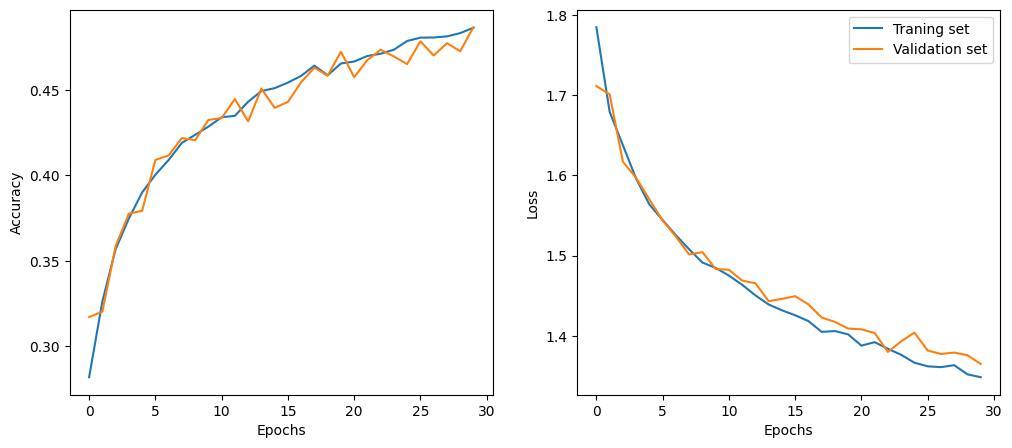

In [ ]:
plot_loss_accuracy(cnn_model_info)

## Model testing

Accuracy is:                  0.539
Precision of each class is:   0.42 0.63 0.44 0.72 0.52 0.38 0.66
Recall of each class is:      0.41 0.11 0.21 0.8 0.47 0.54 0.68
F1_score of each class is:    0.42 0.18 0.29 0.76 0.49 0.45 0.67



Confusion Matrix


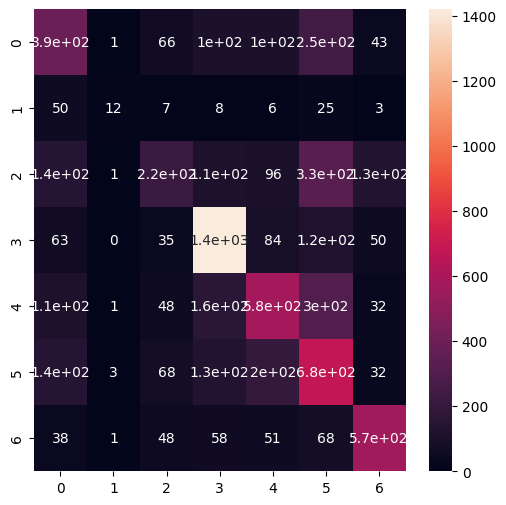

In [ ]:
#Testing the model on test set
test_model(cnn_model,criterion,test_dataloader)

In [ ]:
save_path=os.path.join(WEIGHTS_FOLDER,"cnn_model.pth")
torch.save(cnn_model, save_path)

##2. Attention based CNN model

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        weights = self.sigmoid(self.conv(x))
        return x * weights

class Attn_CNN(nn.Module):
    def __init__(self):
        super(Attn_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.attention = AttentionBlock(32)  # Attention Mechanism
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(1152*4, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(256, 7)

    def forward(self, x):
        out = self.pool1(self.dropout1(self.relu1(self.bn1(self.conv1(x)))))
        out = self.pool2(self.dropout2(self.relu2(self.bn2(self.conv2(out)))))

        # Apply attention mechanism
        out = self.attention(out)

        out = torch.flatten(out, 1)
        out = self.dropout3(self.relu3(self.bn3(self.fc1(out))))
        out = self.fc2(out)
        out = F.log_softmax(out, dim=-1)
        return out

In [ ]:
#Saving model diagram
save_path=os.path.join(DIAGRAM_FOLDER,"attn_cnn_model")
model_graph = draw_graph(Attn_CNN(), input_size=(1,3,48,48), expand_nested=True)
model_graph.visual_graph.render(save_path, format="png", view=True)

'/content/drive/MyDrive/Project Deals/DeepLearning2023/FR_new/Diagram/attn_cnn_model.png'

In [ ]:
# Create a AttnCNN model
attn_cnn_model = Attn_CNN()

# Train your AttnCNN Model
model = attn_cnn_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs=30

attn_cnn_model,attn_cnn_model_info=train_model(num_epochs,model,optimizer,criterion,Attn_CNN)

  3%|▎         | 1/30 [00:45<21:45, 45.01s/it]

Epoch [1/30] : Train Loss: 1.7733, Val Loss: 1.6921,  Train Accuracy: 0.2834, Val Accuracy: 0.3253


  7%|▋         | 2/30 [01:29<20:48, 44.60s/it]

Epoch [2/30] : Train Loss: 1.6630, Val Loss: 1.6225,  Train Accuracy: 0.3423, Val Accuracy: 0.3615


 10%|█         | 3/30 [02:14<20:12, 44.91s/it]

Epoch [3/30] : Train Loss: 1.6034, Val Loss: 1.5668,  Train Accuracy: 0.3722, Val Accuracy: 0.3937


 13%|█▎        | 4/30 [03:00<19:34, 45.16s/it]

Epoch [4/30] : Train Loss: 1.5652, Val Loss: 1.5446,  Train Accuracy: 0.3894, Val Accuracy: 0.4053


 17%|█▋        | 5/30 [03:43<18:34, 44.58s/it]

Epoch [5/30] : Train Loss: 1.5333, Val Loss: 1.5285,  Train Accuracy: 0.4018, Val Accuracy: 0.4117


 20%|██        | 6/30 [04:28<17:49, 44.54s/it]

Epoch [6/30] : Train Loss: 1.5051, Val Loss: 1.4996,  Train Accuracy: 0.4216, Val Accuracy: 0.4291


 23%|██▎       | 7/30 [05:30<19:16, 50.30s/it]

Epoch [7/30] : Train Loss: 1.4854, Val Loss: 1.4805,  Train Accuracy: 0.4265, Val Accuracy: 0.4310


 27%|██▋       | 8/30 [06:15<17:51, 48.69s/it]

Epoch [8/30] : Train Loss: 1.4709, Val Loss: 1.4531,  Train Accuracy: 0.4307, Val Accuracy: 0.4490


 30%|███       | 9/30 [06:59<16:28, 47.06s/it]

Epoch [9/30] : Train Loss: 1.4544, Val Loss: 1.4346,  Train Accuracy: 0.4439, Val Accuracy: 0.4567


 33%|███▎      | 10/30 [08:06<17:47, 53.37s/it]

Epoch [10/30] : Train Loss: 1.4385, Val Loss: 1.4285,  Train Accuracy: 0.4469, Val Accuracy: 0.4581


 37%|███▋      | 11/30 [09:15<18:26, 58.26s/it]

Epoch [11/30] : Train Loss: 1.4305, Val Loss: 1.4177,  Train Accuracy: 0.4461, Val Accuracy: 0.4618


 40%|████      | 12/30 [10:09<17:05, 56.99s/it]

Epoch [12/30] : Train Loss: 1.4222, Val Loss: 1.4091,  Train Accuracy: 0.4494, Val Accuracy: 0.4682


 43%|████▎     | 13/30 [11:11<16:32, 58.36s/it]

Epoch [13/30] : Train Loss: 1.4120, Val Loss: 1.3965,  Train Accuracy: 0.4593, Val Accuracy: 0.4713


 47%|████▋     | 14/30 [11:54<14:19, 53.72s/it]

Epoch [14/30] : Train Loss: 1.4042, Val Loss: 1.3944,  Train Accuracy: 0.4597, Val Accuracy: 0.4762


 50%|█████     | 15/30 [12:37<12:39, 50.63s/it]

Epoch [15/30] : Train Loss: 1.3907, Val Loss: 1.3802,  Train Accuracy: 0.4638, Val Accuracy: 0.4769


 53%|█████▎    | 16/30 [13:21<11:20, 48.59s/it]

Epoch [16/30] : Train Loss: 1.3848, Val Loss: 1.3725,  Train Accuracy: 0.4698, Val Accuracy: 0.4836


 57%|█████▋    | 17/30 [14:04<10:09, 46.85s/it]

Epoch [17/30] : Train Loss: 1.3738, Val Loss: 1.3671,  Train Accuracy: 0.4721, Val Accuracy: 0.4772


 60%|██████    | 18/30 [14:49<09:15, 46.30s/it]

Epoch [18/30] : Train Loss: 1.3664, Val Loss: 1.3542,  Train Accuracy: 0.4796, Val Accuracy: 0.4914


 63%|██████▎   | 19/30 [15:32<08:18, 45.33s/it]

Epoch [19/30] : Train Loss: 1.3584, Val Loss: 1.3488,  Train Accuracy: 0.4775, Val Accuracy: 0.4897


 67%|██████▋   | 20/30 [16:14<07:24, 44.41s/it]

Epoch [20/30] : Train Loss: 1.3533, Val Loss: 1.3568,  Train Accuracy: 0.4831, Val Accuracy: 0.4896


 70%|███████   | 21/30 [16:57<06:33, 43.76s/it]

Epoch [21/30] : Train Loss: 1.3522, Val Loss: 1.3455,  Train Accuracy: 0.4810, Val Accuracy: 0.4976


 73%|███████▎  | 22/30 [17:41<05:51, 43.89s/it]

Epoch [22/30] : Train Loss: 1.3419, Val Loss: 1.3282,  Train Accuracy: 0.4855, Val Accuracy: 0.5011


 77%|███████▋  | 23/30 [18:24<05:05, 43.59s/it]

Epoch [23/30] : Train Loss: 1.3398, Val Loss: 1.3372,  Train Accuracy: 0.4856, Val Accuracy: 0.4979


 80%|████████  | 24/30 [19:06<04:19, 43.30s/it]

Epoch [24/30] : Train Loss: 1.3300, Val Loss: 1.3306,  Train Accuracy: 0.4924, Val Accuracy: 0.4985


 83%|████████▎ | 25/30 [19:49<03:35, 43.19s/it]

Epoch [25/30] : Train Loss: 1.3220, Val Loss: 1.3190,  Train Accuracy: 0.4969, Val Accuracy: 0.4965


 87%|████████▋ | 26/30 [20:32<02:52, 43.06s/it]

Epoch [26/30] : Train Loss: 1.3251, Val Loss: 1.3229,  Train Accuracy: 0.4892, Val Accuracy: 0.4968


 90%|█████████ | 27/30 [21:17<02:10, 43.49s/it]

Epoch [27/30] : Train Loss: 1.3166, Val Loss: 1.3115,  Train Accuracy: 0.4983, Val Accuracy: 0.5077


 93%|█████████▎| 28/30 [22:00<01:26, 43.31s/it]

Epoch [28/30] : Train Loss: 1.3182, Val Loss: 1.3124,  Train Accuracy: 0.4931, Val Accuracy: 0.5035


 97%|█████████▋| 29/30 [22:42<00:42, 42.94s/it]

Epoch [29/30] : Train Loss: 1.3048, Val Loss: 1.3092,  Train Accuracy: 0.5047, Val Accuracy: 0.4992


100%|██████████| 30/30 [23:24<00:00, 46.81s/it]

Epoch [30/30] : Train Loss: 1.3030, Val Loss: 1.3065,  Train Accuracy: 0.4966, Val Accuracy: 0.5098


## Accuracy plot

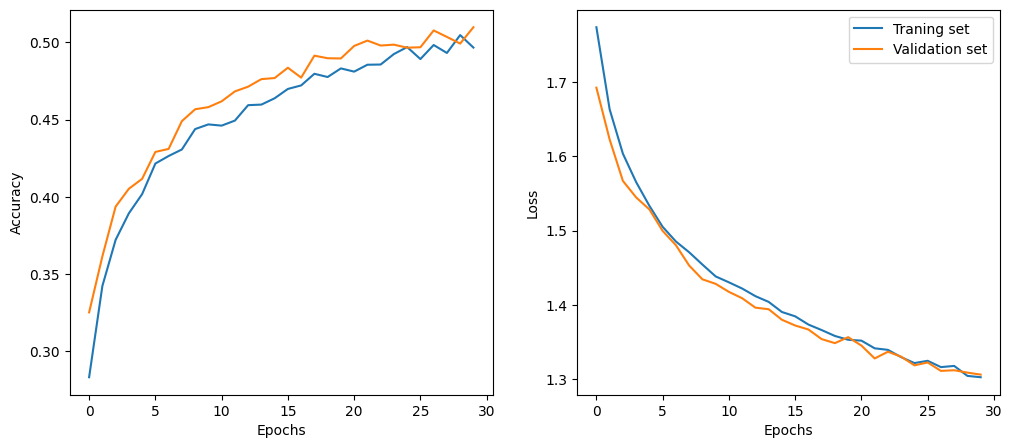

In [ ]:
plot_loss_accuracy(attn_cnn_model_info)

## Model Testing

Accuracy is:                  0.552
Precision of each class is:   0.46 0.57 0.42 0.74 0.51 0.41 0.61
Recall of each class is:      0.39 0.23 0.23 0.8 0.55 0.48 0.76
F1_score of each class is:    0.42 0.32 0.29 0.77 0.53 0.44 0.67



Confusion Matrix


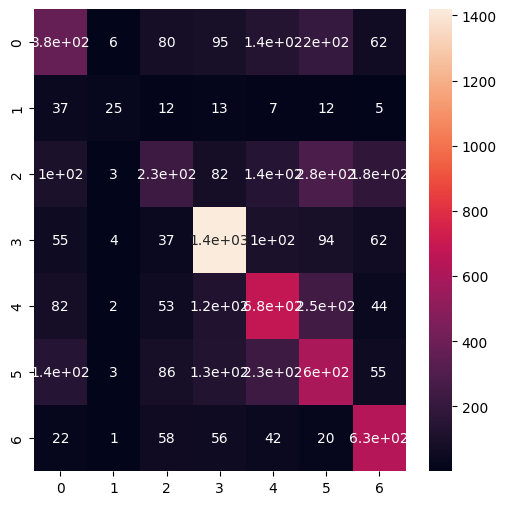

In [ ]:
#Testing the model on test set
test_model(attn_cnn_model,criterion,test_dataloader)

In [ ]:
save_path=os.path.join(WEIGHTS_FOLDER,"attn_cnn_model.pth")
torch.save(attn_cnn_model, save_path)

#3. Fusion model of based on concept of Unet, Resnet and Google net inception blocks

In [ ]:
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
        super(InceptionBlock, self).__init__()
        # 1x1 conv branch
        self.branch1x1 = nn.Conv2d(in_channels, out_1x1, kernel_size=1)

        # 1x1 conv -> 3x3 conv branch
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, red_3x3, kernel_size=1),
            nn.Conv2d(red_3x3, out_3x3, kernel_size=3, padding=1)
        )

        # 1x1 conv -> 5x5 conv branch
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, red_5x5, kernel_size=1),
            nn.Conv2d(red_5x5, out_5x5, kernel_size=5, padding=2)
        )

        # 3x3 max pool -> 1x1 conv branch
        self.branch1x1pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_1x1pool, kernel_size=1)
        )

    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch1x1pool = self.branch1x1pool(x)

        outputs = [branch1x1, branch3x3, branch5x5, branch1x1pool]
        return torch.cat(outputs, 1)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

class FusionCNN(nn.Module):
    def __init__(self):
        super(FusionCNN, self).__init__()
        # Encoder (U-Net-like structure)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.res_block1 = ResidualBlock(64, 128, stride=2)
        self.incept_block1 = InceptionBlock(128, 32, 32, 64, 16, 16, 16)
        self.res_block2 = ResidualBlock(128, 256, stride=2)
        self.incept_block2 = InceptionBlock(256, 64, 64, 128, 32, 32, 32)

        # Decoder (U-Net-like structure)
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.res_block3 = ResidualBlock(128, 128)
        self.incept_block3 = InceptionBlock(128, 32, 32, 64, 16, 16, 16)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.res_block4 = ResidualBlock(64, 64)
        self.incept_block4 = InceptionBlock(64, 16, 16, 32, 8, 8, 8)

        # Classifier
        self.global_avg_pooling = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, 7)

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        x = self.res_block1(x)
        x = self.incept_block1(x)
        x = self.res_block2(x)
        x = self.incept_block2(x)

        # Decoder
        x = self.deconv1(x)
        x = self.res_block3(x)
        x = self.incept_block3(x)
        x = self.deconv2(x)
        x = self.res_block4(x)
        x = self.incept_block4(x)

        # Classifier
        x = self.global_avg_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return F.log_softmax(x, dim=-1)

In [ ]:
# #Saving model diagram
save_path=os.path.join(DIAGRAM_FOLDER,"fusion_cnn_model")
model_graph = draw_graph(FusionCNN(), input_size=(1,3,48,48), expand_nested=True)
model_graph.visual_graph.render(save_path, format="png", view=True)

'/content/drive/MyDrive/Project Deals/DeepLearning2023/FR_new/Diagram/fusion_cnn_model.png'

In [ ]:
# Create a AttnCNN model
fusion_cnn_model = FusionCNN()

# Train your AttnCNN Model
model = fusion_cnn_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs=30

fusion_cnn_model,fusion_cnn_model_info=train_model(num_epochs,model,optimizer,criterion,FusionCNN)

  3%|▎         | 1/30 [01:16<37:02, 76.63s/it]

Epoch [1/30] : Train Loss: 1.7986, Val Loss: 1.7789,  Train Accuracy: 0.2537, Val Accuracy: 0.2595


  7%|▋         | 2/30 [02:33<35:46, 76.67s/it]

Epoch [2/30] : Train Loss: 1.7452, Val Loss: 1.7593,  Train Accuracy: 0.2806, Val Accuracy: 0.2750


 10%|█         | 3/30 [03:48<34:13, 76.04s/it]

Epoch [3/30] : Train Loss: 1.6200, Val Loss: 1.6736,  Train Accuracy: 0.3446, Val Accuracy: 0.3341


 13%|█▎        | 4/30 [05:03<32:49, 75.74s/it]

Epoch [4/30] : Train Loss: 1.4973, Val Loss: 1.5608,  Train Accuracy: 0.4125, Val Accuracy: 0.3947


 17%|█▋        | 5/30 [06:19<31:34, 75.79s/it]

Epoch [5/30] : Train Loss: 1.4147, Val Loss: 1.4481,  Train Accuracy: 0.4531, Val Accuracy: 0.4550


 20%|██        | 6/30 [07:35<30:14, 75.62s/it]

Epoch [6/30] : Train Loss: 1.3553, Val Loss: 1.3318,  Train Accuracy: 0.4730, Val Accuracy: 0.4918


 23%|██▎       | 7/30 [08:50<29:00, 75.68s/it]

Epoch [7/30] : Train Loss: 1.3116, Val Loss: 1.3259,  Train Accuracy: 0.4991, Val Accuracy: 0.4890


 27%|██▋       | 8/30 [10:07<27:51, 75.96s/it]

Epoch [8/30] : Train Loss: 1.2807, Val Loss: 1.3314,  Train Accuracy: 0.5072, Val Accuracy: 0.4904


 30%|███       | 9/30 [11:22<26:32, 75.81s/it]

Epoch [9/30] : Train Loss: 1.2469, Val Loss: 1.2449,  Train Accuracy: 0.5249, Val Accuracy: 0.5290


 33%|███▎      | 10/30 [12:38<25:15, 75.79s/it]

Epoch [10/30] : Train Loss: 1.2164, Val Loss: 1.2320,  Train Accuracy: 0.5384, Val Accuracy: 0.5339


 37%|███▋      | 11/30 [13:55<24:04, 76.02s/it]

Epoch [11/30] : Train Loss: 1.1944, Val Loss: 1.2270,  Train Accuracy: 0.5469, Val Accuracy: 0.5354


 40%|████      | 12/30 [15:10<22:45, 75.87s/it]

Epoch [12/30] : Train Loss: 1.1750, Val Loss: 1.1903,  Train Accuracy: 0.5569, Val Accuracy: 0.5485


 43%|████▎     | 13/30 [16:28<21:37, 76.34s/it]

Epoch [13/30] : Train Loss: 1.1561, Val Loss: 1.2999,  Train Accuracy: 0.5619, Val Accuracy: 0.5095


 47%|████▋     | 14/30 [17:43<20:18, 76.18s/it]

Epoch [14/30] : Train Loss: 1.1378, Val Loss: 1.3068,  Train Accuracy: 0.5720, Val Accuracy: 0.5191


 50%|█████     | 15/30 [18:59<19:00, 76.01s/it]

Epoch [15/30] : Train Loss: 1.1140, Val Loss: 1.1904,  Train Accuracy: 0.5813, Val Accuracy: 0.5542


 53%|█████▎    | 16/30 [20:16<17:47, 76.25s/it]

Epoch [16/30] : Train Loss: 1.1072, Val Loss: 1.1589,  Train Accuracy: 0.5804, Val Accuracy: 0.5641


 57%|█████▋    | 17/30 [21:32<16:30, 76.21s/it]

Epoch [17/30] : Train Loss: 1.0930, Val Loss: 1.1831,  Train Accuracy: 0.5862, Val Accuracy: 0.5593


 60%|██████    | 18/30 [22:48<15:12, 76.04s/it]

Epoch [18/30] : Train Loss: 1.0740, Val Loss: 1.2085,  Train Accuracy: 0.5953, Val Accuracy: 0.5536


 63%|██████▎   | 19/30 [24:05<14:00, 76.38s/it]

Epoch [19/30] : Train Loss: 1.0638, Val Loss: 1.1252,  Train Accuracy: 0.5996, Val Accuracy: 0.5730


 67%|██████▋   | 20/30 [25:23<12:49, 76.97s/it]

Epoch [20/30] : Train Loss: 1.0578, Val Loss: 1.1615,  Train Accuracy: 0.6020, Val Accuracy: 0.5744


 70%|███████   | 21/30 [26:42<11:36, 77.42s/it]

Epoch [21/30] : Train Loss: 1.0428, Val Loss: 1.1192,  Train Accuracy: 0.6088, Val Accuracy: 0.5826


 73%|███████▎  | 22/30 [27:58<10:15, 76.98s/it]

Epoch [22/30] : Train Loss: 1.0353, Val Loss: 1.1521,  Train Accuracy: 0.6112, Val Accuracy: 0.5776


 77%|███████▋  | 23/30 [29:14<08:56, 76.67s/it]

Epoch [23/30] : Train Loss: 1.0219, Val Loss: 1.1060,  Train Accuracy: 0.6157, Val Accuracy: 0.5890


 80%|████████  | 24/30 [30:30<07:40, 76.72s/it]

Epoch [24/30] : Train Loss: 1.0166, Val Loss: 1.0978,  Train Accuracy: 0.6182, Val Accuracy: 0.5875


 83%|████████▎ | 25/30 [31:46<06:22, 76.45s/it]

Epoch [25/30] : Train Loss: 1.0012, Val Loss: 1.1517,  Train Accuracy: 0.6247, Val Accuracy: 0.5729


 87%|████████▋ | 26/30 [33:02<05:05, 76.31s/it]

Epoch [26/30] : Train Loss: 0.9959, Val Loss: 1.0709,  Train Accuracy: 0.6288, Val Accuracy: 0.5995


 90%|█████████ | 27/30 [34:19<03:49, 76.55s/it]

Epoch [27/30] : Train Loss: 0.9845, Val Loss: 1.2047,  Train Accuracy: 0.6320, Val Accuracy: 0.5616


 93%|█████████▎| 28/30 [35:36<02:33, 76.51s/it]

Epoch [28/30] : Train Loss: 0.9808, Val Loss: 1.0977,  Train Accuracy: 0.6276, Val Accuracy: 0.5900


 97%|█████████▋| 29/30 [36:53<01:16, 76.76s/it]

Epoch [29/30] : Train Loss: 0.9609, Val Loss: 1.1161,  Train Accuracy: 0.6420, Val Accuracy: 0.5880


100%|██████████| 30/30 [38:09<00:00, 76.31s/it]

Epoch [30/30] : Train Loss: 0.9612, Val Loss: 1.1201,  Train Accuracy: 0.6420, Val Accuracy: 0.5883


##Accuracy plot

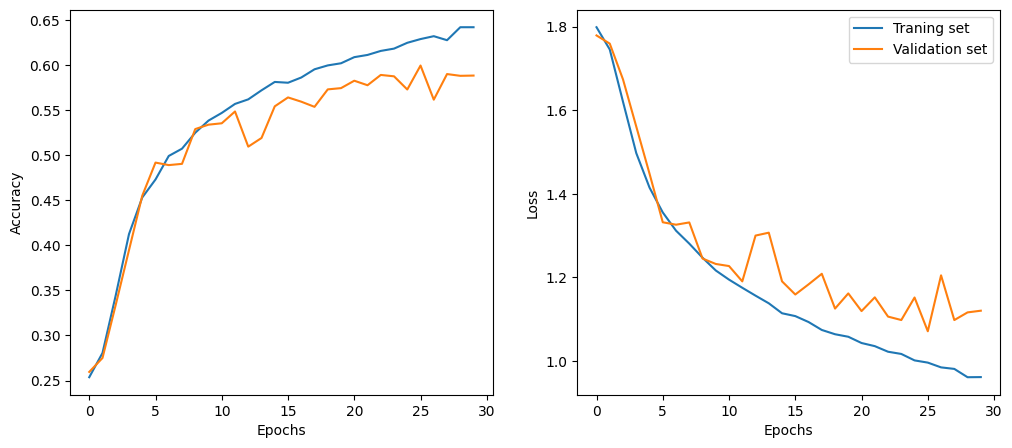

In [ ]:
plot_loss_accuracy(fusion_cnn_model_info)

##Model testing

Accuracy is:                  0.608
Precision of each class is:   0.58 0.88 0.38 0.91 0.49 0.56 0.7
Recall of each class is:      0.52 0.13 0.45 0.78 0.74 0.34 0.79
F1_score of each class is:    0.55 0.22 0.41 0.84 0.59 0.43 0.74



Confusion Matrix


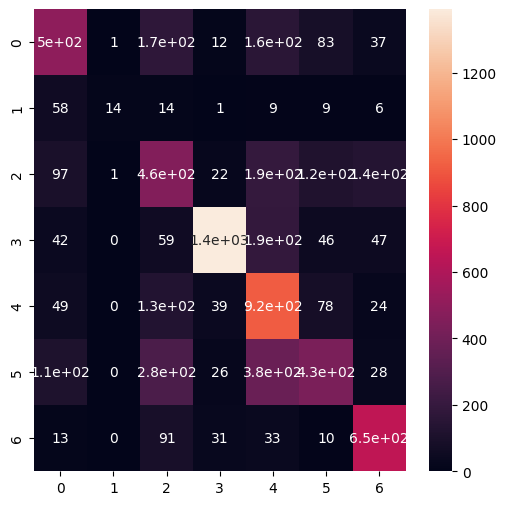

In [ ]:
#Testing the model on test set
test_model(fusion_cnn_model,criterion,test_dataloader)

In [ ]:
save_path=os.path.join(WEIGHTS_FOLDER,"fusion_cnn_model.pth")
torch.save(fusion_cnn_model, save_path)

#4. Fusion model of Shuffle Net, Reduction cell of Nasnet modela and Encoder decoder.

In [56]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

class ShuffleNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, groups=3):
        super(ShuffleNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=1, groups=in_channels, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, groups=in_channels, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.bn3(out)
        return out

class ReductionCell(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ReductionCell, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out1 = self.conv1(x)
        out1 = self.bn1(out1)
        out1 = self.relu(out1)
        out1 = self.conv2(out1)
        out1 = self.bn2(out1)

        out2 = self.conv3(x)
        out2 = self.bn3(out2)

        return torch.cat([out1, out2], dim=1)

class NasUnet(nn.Module):
    def __init__(self):
        super(NasUnet, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)

        # ResNet Blocks
        self.res_block1 = ResidualBlock(64, 128, stride=2)
        self.res_block2 = ResidualBlock(128, 256, stride=2)

        # ShuffleNet Blocks
        self.shufflenet_block1 = ShuffleNetBlock(256, 512)
        self.shufflenet_block2 = ShuffleNetBlock(512, 1024)

        # Reduction Cell
        self.reduction_cell = ReductionCell(1024, 256)

        # Decoder (U-Net-like structure)
        self.deconv1 = nn.ConvTranspose2d(512, 128, kernel_size=2, stride=2)
        self.dec_res_block1 = ResidualBlock(128, 64, stride=1)
        self.deconv2 = nn.ConvTranspose2d(192, 64, kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(96, 7, kernel_size=1, stride=1, padding=0)

        self.global_avg_pooling = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(4032, 7)

    def forward(self, x):
        # Encoder
        x = F.relu(self.conv1(x))
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.shufflenet_block1(x)
        x = self.shufflenet_block2(x)
        x = self.reduction_cell(x)

        # Decoder
        x = F.relu(self.deconv1(x))
        x = torch.cat([x, self.dec_res_block1(x)], dim=1)
        x = F.relu(self.deconv2(x))
        x = torch.cat([x, self.conv2(x)], dim=1)
        x = self.conv3(x)

        # x = self.global_avg_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return F.log_softmax(x, dim=1)

In [62]:
# #Saving model diagram
save_path=os.path.join(DIAGRAM_FOLDER,"nas_unet_cnn_model")
model_graph = draw_graph(NasUnet(), input_size=(1,3,48,48), expand_nested=True)
model_graph.visual_graph.render(save_path, format="png", view=True)

'/content/drive/MyDrive/Project Deals/DeepLearning2023/FR_new/Diagram/nas_unet_cnn_model.png'

In [57]:
# Create a AttnCNN model
nas_unet_cnn_model = NasUnet()

# Train your AttnCNN Model
model = nas_unet_cnn_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs=30

nas_unet_cnn_model,nas_unet_cnn_model_info=train_model(num_epochs,model,optimizer,criterion,NasUnet)

  3%|▎         | 1/30 [01:06<32:20, 66.91s/it]

Epoch [1/30] : Train Loss: 1.7878, Val Loss: 1.7734,  Train Accuracy: 0.2585, Val Accuracy: 0.2647


  7%|▋         | 2/30 [02:15<31:44, 68.03s/it]

Epoch [2/30] : Train Loss: 1.7327, Val Loss: 1.7457,  Train Accuracy: 0.2942, Val Accuracy: 0.2942


 10%|█         | 3/30 [03:22<30:19, 67.39s/it]

Epoch [3/30] : Train Loss: 1.6433, Val Loss: 1.5994,  Train Accuracy: 0.3527, Val Accuracy: 0.3774


 13%|█▎        | 4/30 [04:29<29:09, 67.29s/it]

Epoch [4/30] : Train Loss: 1.5507, Val Loss: 1.5518,  Train Accuracy: 0.3946, Val Accuracy: 0.3876


 17%|█▋        | 5/30 [05:37<28:13, 67.72s/it]

Epoch [5/30] : Train Loss: 1.4754, Val Loss: 1.4955,  Train Accuracy: 0.4259, Val Accuracy: 0.4185


 20%|██        | 6/30 [06:44<26:55, 67.33s/it]

Epoch [6/30] : Train Loss: 1.4091, Val Loss: 1.4183,  Train Accuracy: 0.4588, Val Accuracy: 0.4418


 23%|██▎       | 7/30 [07:51<25:48, 67.30s/it]

Epoch [7/30] : Train Loss: 1.3561, Val Loss: 1.3631,  Train Accuracy: 0.4826, Val Accuracy: 0.4798


 27%|██▋       | 8/30 [08:59<24:41, 67.36s/it]

Epoch [8/30] : Train Loss: 1.3124, Val Loss: 1.3571,  Train Accuracy: 0.4981, Val Accuracy: 0.4756


 30%|███       | 9/30 [10:07<23:41, 67.68s/it]

Epoch [9/30] : Train Loss: 1.2816, Val Loss: 1.2939,  Train Accuracy: 0.5121, Val Accuracy: 0.5098


 33%|███▎      | 10/30 [11:15<22:32, 67.64s/it]

Epoch [10/30] : Train Loss: 1.2502, Val Loss: 1.2826,  Train Accuracy: 0.5242, Val Accuracy: 0.5074


 37%|███▋      | 11/30 [12:22<21:22, 67.49s/it]

Epoch [11/30] : Train Loss: 1.2201, Val Loss: 1.2660,  Train Accuracy: 0.5343, Val Accuracy: 0.5220


 40%|████      | 12/30 [13:31<20:21, 67.86s/it]

Epoch [12/30] : Train Loss: 1.2003, Val Loss: 1.2331,  Train Accuracy: 0.5446, Val Accuracy: 0.5322


 43%|████▎     | 13/30 [14:38<19:10, 67.66s/it]

Epoch [13/30] : Train Loss: 1.1759, Val Loss: 1.2075,  Train Accuracy: 0.5543, Val Accuracy: 0.5442


 47%|████▋     | 14/30 [15:46<18:03, 67.73s/it]

Epoch [14/30] : Train Loss: 1.1565, Val Loss: 1.1832,  Train Accuracy: 0.5633, Val Accuracy: 0.5553


 50%|█████     | 15/30 [16:54<16:58, 67.93s/it]

Epoch [15/30] : Train Loss: 1.1418, Val Loss: 1.1921,  Train Accuracy: 0.5709, Val Accuracy: 0.5437


 53%|█████▎    | 16/30 [18:02<15:50, 67.90s/it]

Epoch [16/30] : Train Loss: 1.1284, Val Loss: 1.1823,  Train Accuracy: 0.5729, Val Accuracy: 0.5521


 57%|█████▋    | 17/30 [19:09<14:40, 67.73s/it]

Epoch [17/30] : Train Loss: 1.1170, Val Loss: 1.1517,  Train Accuracy: 0.5791, Val Accuracy: 0.5630


 60%|██████    | 18/30 [20:18<13:37, 68.10s/it]

Epoch [18/30] : Train Loss: 1.0977, Val Loss: 1.2097,  Train Accuracy: 0.5869, Val Accuracy: 0.5385


 63%|██████▎   | 19/30 [21:25<12:25, 67.79s/it]

Epoch [19/30] : Train Loss: 1.0890, Val Loss: 1.1433,  Train Accuracy: 0.5824, Val Accuracy: 0.5644


 67%|██████▋   | 20/30 [22:32<11:15, 67.52s/it]

Epoch [20/30] : Train Loss: 1.0694, Val Loss: 1.1392,  Train Accuracy: 0.5945, Val Accuracy: 0.5665


 70%|███████   | 21/30 [23:40<10:07, 67.55s/it]

Epoch [21/30] : Train Loss: 1.0661, Val Loss: 1.1332,  Train Accuracy: 0.5967, Val Accuracy: 0.5639


 73%|███████▎  | 22/30 [24:48<09:01, 67.63s/it]

Epoch [22/30] : Train Loss: 1.0546, Val Loss: 1.1461,  Train Accuracy: 0.5998, Val Accuracy: 0.5748


 77%|███████▋  | 23/30 [25:55<07:53, 67.69s/it]

Epoch [23/30] : Train Loss: 1.0366, Val Loss: 1.1083,  Train Accuracy: 0.6096, Val Accuracy: 0.5798


 80%|████████  | 24/30 [27:02<06:44, 67.43s/it]

Epoch [24/30] : Train Loss: 1.0369, Val Loss: 1.1224,  Train Accuracy: 0.6070, Val Accuracy: 0.5800


 83%|████████▎ | 25/30 [28:11<05:39, 67.81s/it]

Epoch [25/30] : Train Loss: 1.0192, Val Loss: 1.0933,  Train Accuracy: 0.6170, Val Accuracy: 0.5946


 87%|████████▋ | 26/30 [29:17<04:29, 67.31s/it]

Epoch [26/30] : Train Loss: 1.0139, Val Loss: 1.0913,  Train Accuracy: 0.6163, Val Accuracy: 0.5926


 90%|█████████ | 27/30 [30:24<03:21, 67.20s/it]

Epoch [27/30] : Train Loss: 1.0094, Val Loss: 1.1012,  Train Accuracy: 0.6172, Val Accuracy: 0.5833


 93%|█████████▎| 28/30 [31:32<02:14, 67.35s/it]

Epoch [28/30] : Train Loss: 0.9988, Val Loss: 1.0958,  Train Accuracy: 0.6232, Val Accuracy: 0.5935


 97%|█████████▋| 29/30 [32:39<01:07, 67.25s/it]

Epoch [29/30] : Train Loss: 0.9865, Val Loss: 1.1111,  Train Accuracy: 0.6289, Val Accuracy: 0.5867


100%|██████████| 30/30 [33:46<00:00, 67.54s/it]

Epoch [30/30] : Train Loss: 0.9834, Val Loss: 1.1205,  Train Accuracy: 0.6324, Val Accuracy: 0.5919


##Accuracy plot

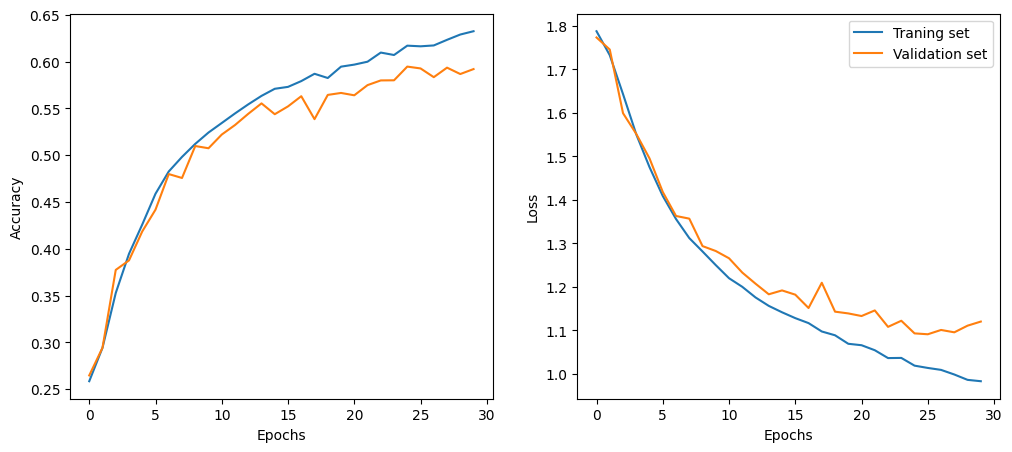

In [58]:
plot_loss_accuracy(nas_unet_cnn_model_info)

##Model testing

Accuracy is:                  0.614
Precision of each class is:   0.61 0.45 0.49 0.8 0.49 0.51 0.7
Recall of each class is:      0.41 0.42 0.36 0.88 0.73 0.42 0.76
F1_score of each class is:    0.49 0.44 0.41 0.84 0.59 0.46 0.73



Confusion Matrix


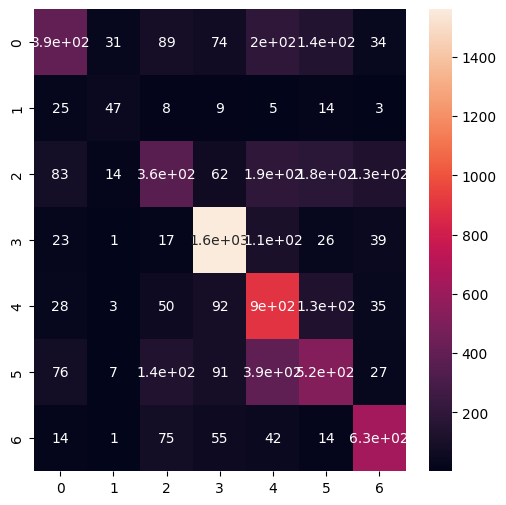

In [60]:
#Testing the model on test set
test_model(nas_unet_cnn_model,criterion,test_dataloader)

In [61]:
save_path=os.path.join(WEIGHTS_FOLDER,"nas_unet_cnn_model.pth")
torch.save(nas_unet_cnn_model, save_path)